# NOTE: this is an incorrect formulation of the solution

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from aging.behavior.syllables import relabel_by_usage
from sklearn.decomposition import PCA

In [14]:
def zscore(df):
    return (df - df.mean()) / df.std()

def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9

In [7]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet')
df, usage_map = relabel_by_usage(df)
df['age'] = df['age'].map(age_map)

usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()

usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)

In [11]:
pca = PCA(n_components=20)
pcs = pca.fit_transform(usage_mtx)

In [19]:
pc_df = pd.DataFrame(pcs, columns=[f'pc_{i:02d}' for i in range(1, pcs.shape[1] + 1)], index=usage_mtx.index)
pc_df = zscore(pc_df)

In [26]:
ages = sorted(pc_df.index.get_level_values('age').unique().astype(int))

## Create dynamical system with pytorch

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [70]:
class DynamicalDataset(Dataset):
    def __init__(self, df, n_lags=1, n_dim=10) -> None:
        super().__init__()
        self.df = df.iloc[:, :n_dim]
        self.ages = sorted(df.index.get_level_values('age').unique().astype(int))
        self.n_lags = n_lags

    def __len__(self) -> int:
        return len(self.ages) - self.n_lags

    def __getitem__(self, idx: int) -> torch.Tensor:
        age_diff = (self.ages[idx + self.n_lags] - self.ages[idx]) / 100
        sample = self.df.loc[self.ages[idx]].sample(n=1)
        endpoint = self.df.loc[self.ages[idx + self.n_lags]].sample(n=1)
        return torch.tensor(sample.values, dtype=torch.float), torch.tensor(endpoint.values, dtype=torch.float), torch.tensor(age_diff)

In [71]:
n_dim = 10
n_lags = 1
data = DynamicalDataset(pc_df, n_lags=n_lags, n_dim=n_dim)

In [89]:
a = torch.randn(n_lags, n_dim, n_dim, requires_grad=True)
n_epochs = 100
optim = torch.optim.Adam([a], lr=1e-7)
pbar = tqdm(range(n_epochs))
agg_losses = []
for i in pbar:
    losses = []
    for batch in DataLoader(data, batch_size=10, shuffle=True):
        pred = torch.einsum('ijk,ikl->ijl', batch[0], a * batch[2].view(-1, 1, 1))
        loss = F.mse_loss(pred, batch[1])
        loss.backward()
        optim.step()
        optim.zero_grad()
        losses.append(loss.item())
    pbar.set_description(f'loss: {np.mean(losses):.3f}')
    agg_losses.append(np.mean(losses))

  0%|          | 0/100 [00:00<?, ?it/s]

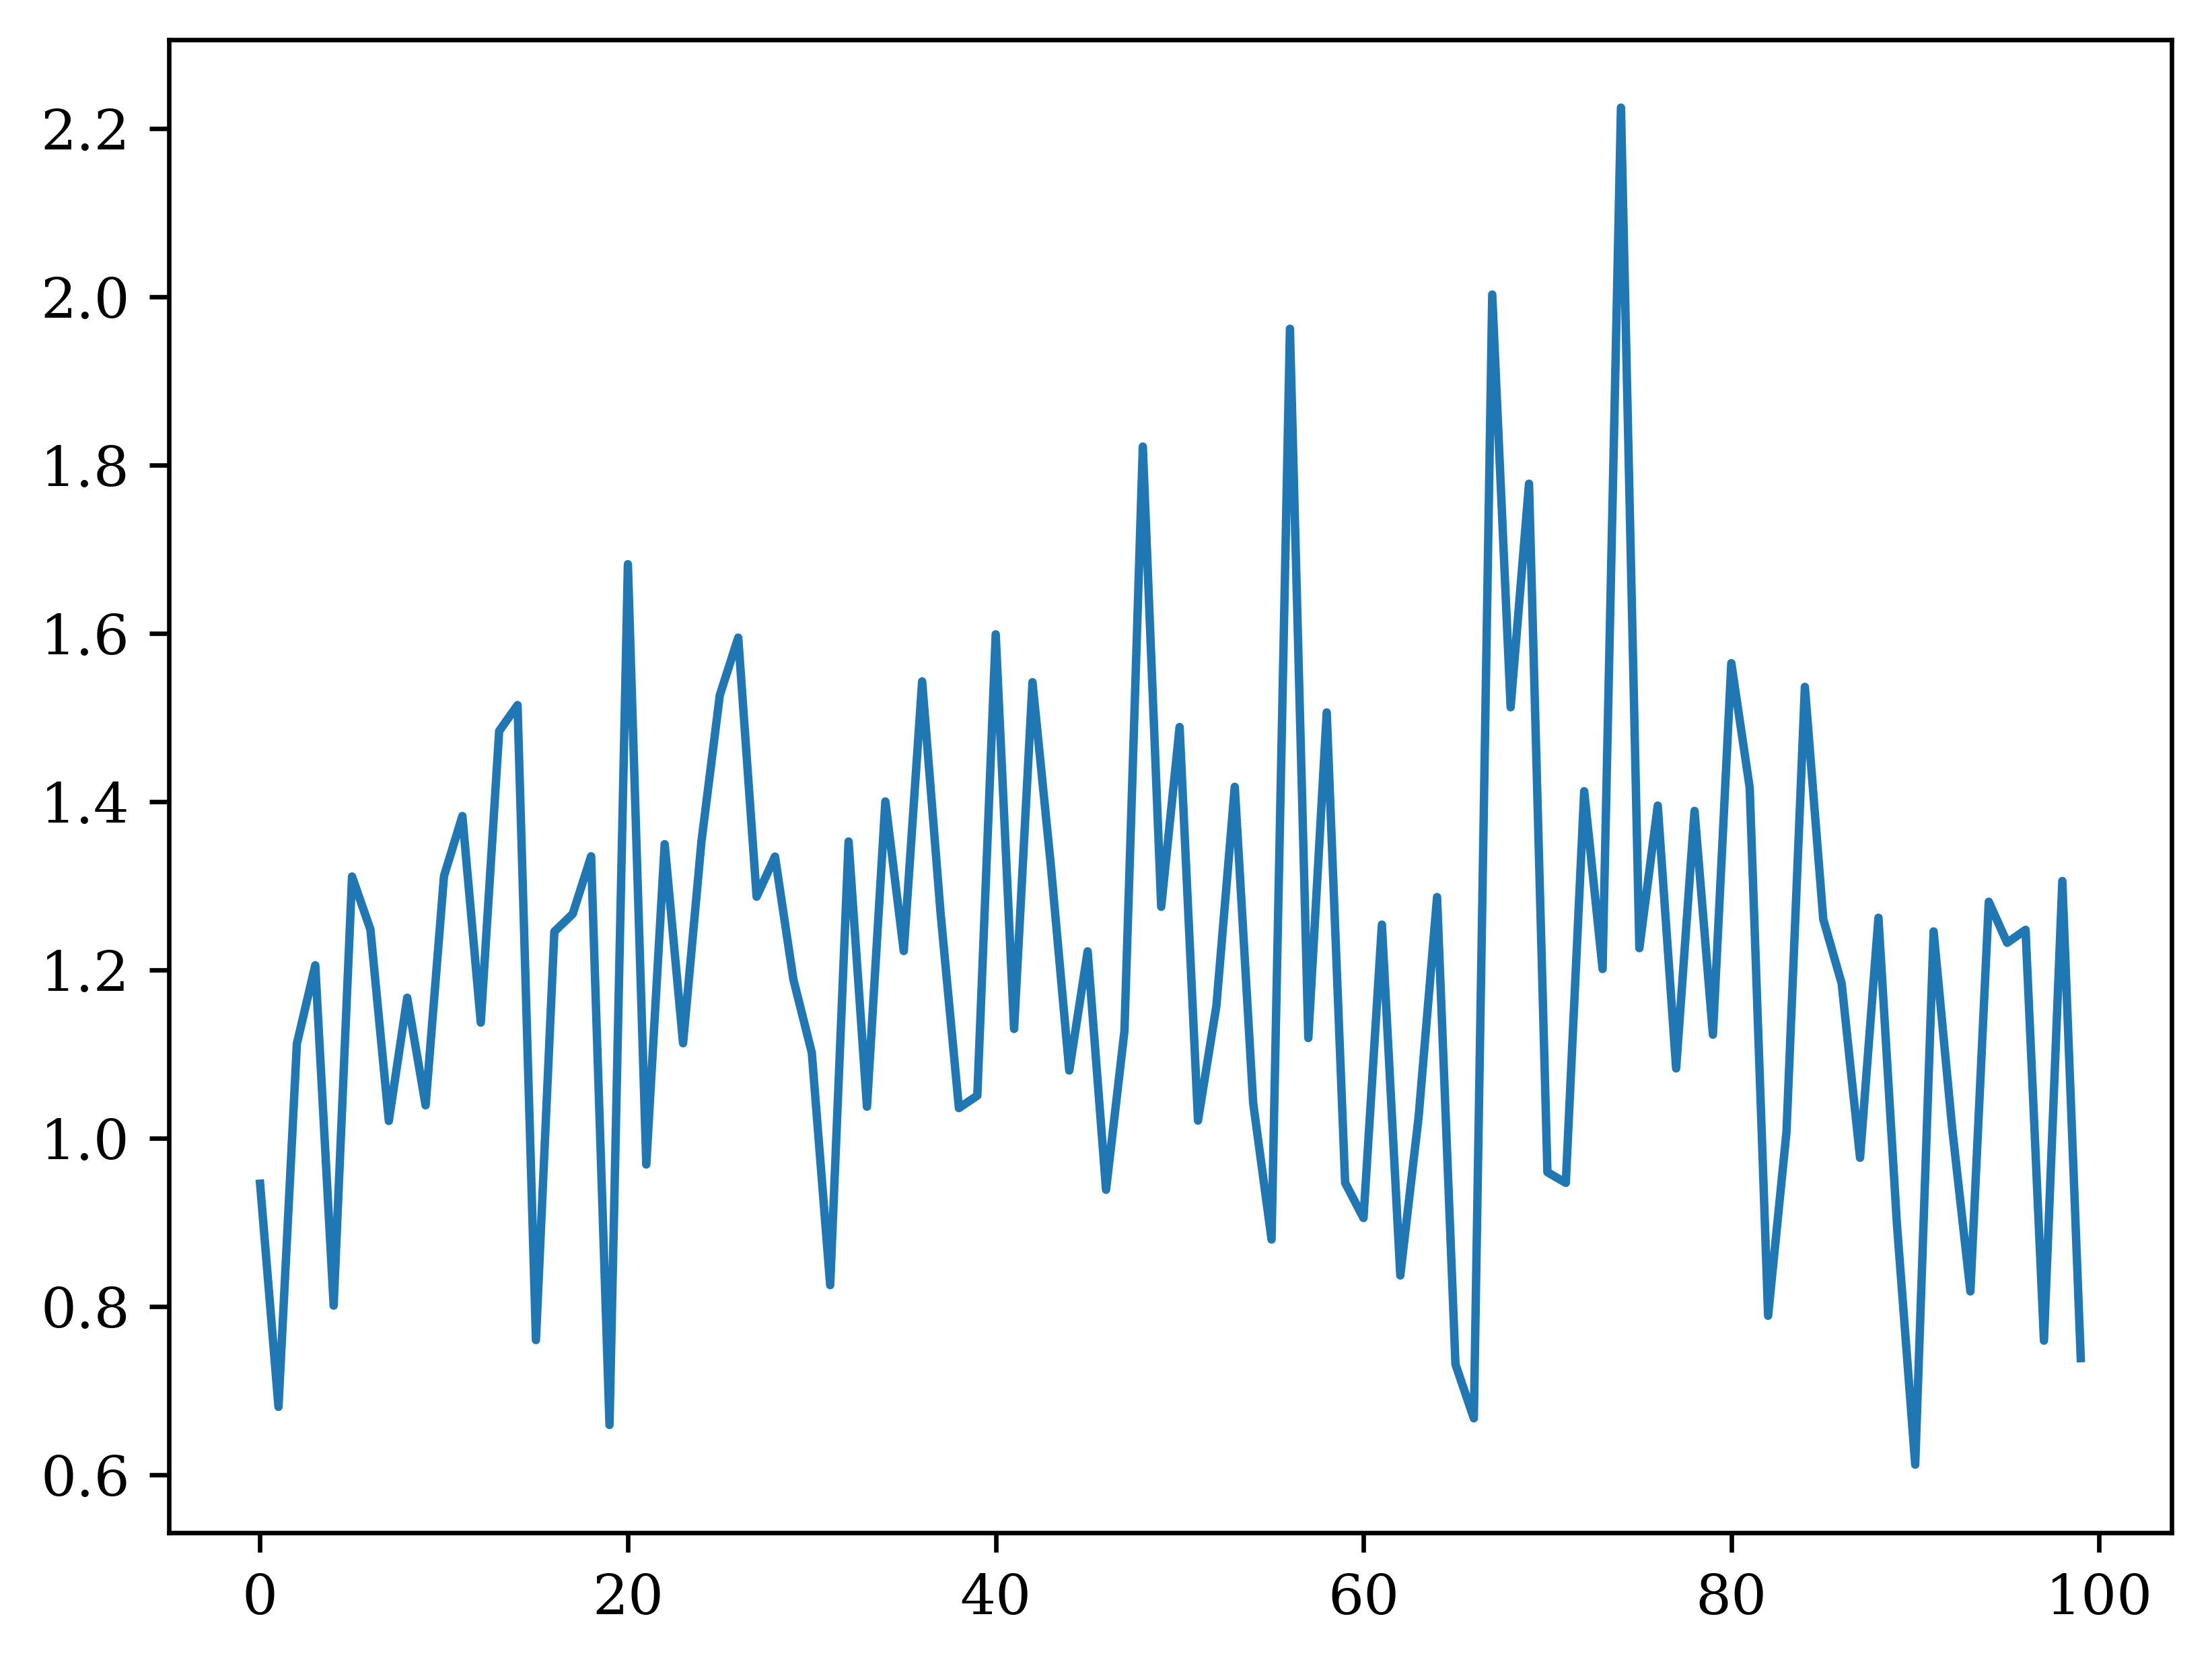

In [90]:
plt.plot(agg_losses)

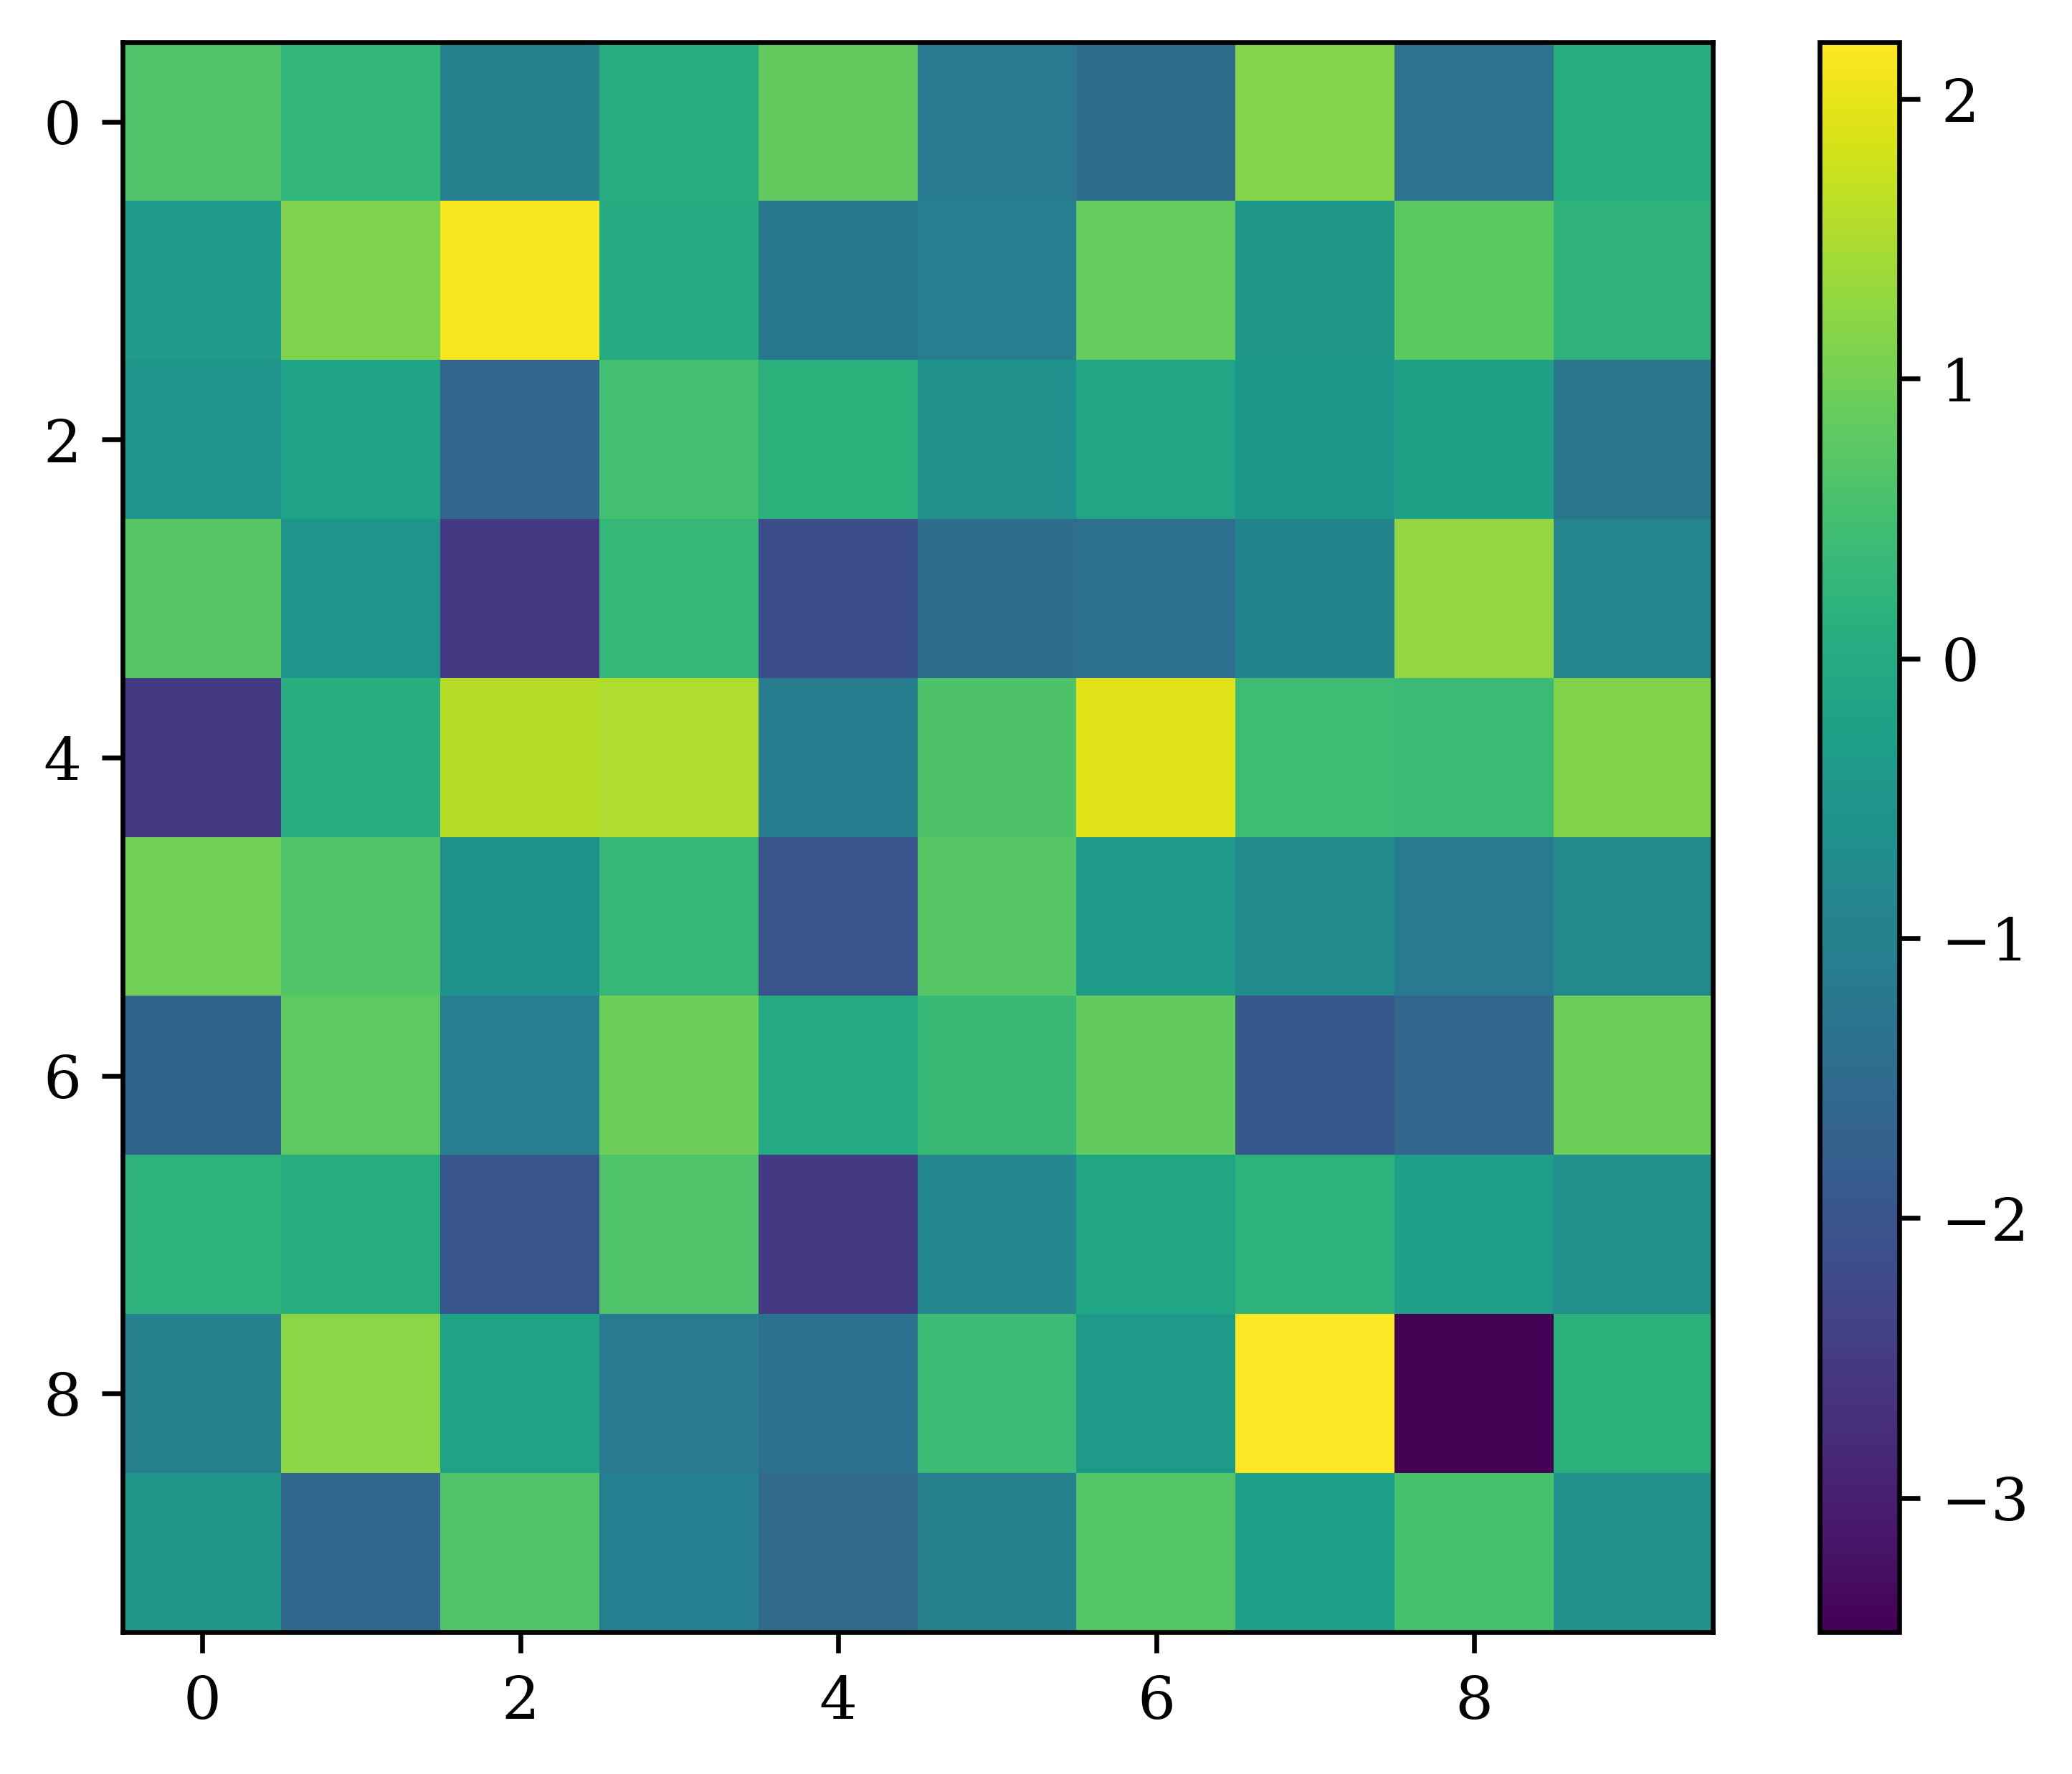

In [91]:
plt.imshow(a.detach().squeeze())
plt.colorbar()